In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from tqdm import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x

In [2]:
# TODO, improvement ideas

# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features
# CV2 resize cubic interpolation 

# Serge:
# essayer de remplacer lgb par un Deep NN keras (vu la quantité de donnée)


#done
# lgbm eval rmsle instead of rmse
# add image size as feature



In [3]:
# memory debug function

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
        for x in dir() 
           if not x.startswith('_') 
#         and x not in sys.modules
        and x not in ipython_vars], key=lambda x: x[1], reverse=True)




## data folder set up and test

In [4]:
dataFolder = 'data/mainData/'
plt.ion()

runNameParams = []
runNameParams.append('newSource')
# print(runNameParams)

In [5]:
def read_image(id):
    if id[-4:] == '.npy':
        X = np.load(dataFolder+id)
    elif os.path.isfile(dataFolder+id+'.npy'):
        X = np.load(dataFolder+id + '.npy')
    elif os.path.isfile(dataFolder+id+'-g.csv'):
        X = np.genfromtxt(dataFolder+id+'-g.csv', delimiter=",")
    else:
        X = None

    X = np.float32(X)
    return X


In [6]:
dataFileList = []

directory = os.fsencode(dataFolder)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy") or filename.endswith(".py"): 
        dataFileList.append(filename)
        
print(len(dataFileList))

80306


# Old cleanup function(for testing purposes)

In [7]:
BlackHighThreshold = 0.1 # the definition of 'black' to determine the radius of a non galaxy object, in luminance
PeakExclusionRadius = 0.1 # the radius around the center within which we ignore luminosity peaks, expressed as an image percentage
NonClearingRadius = 0.1 # the radius around the center within which we don't clean (even with peaks outside)
ObjectLuminosityPercentage = 0.7 # the peak luminosity threshold that we remove points around, expressed as a percentage of the peak center luminosity
valueWhenRemovingPixel = 0 # -55 when debugging, 0 when running

def removeNegs(na):
    for i in range(len(na)):
        for j in range(len(na)):
            na[i][j] = max(0,na[i][j])

    return na

def normalizeInt(na):
    ma = np.amax(na)
    mi = np.amin(na)

    na = na * (ma - mi)
    return na

def removePeakAtPosition(data, x, y, size):
    global BlackHighThreshold
    global valueWhenRemovingPixel
    imagewidth = len(data)
    center = imagewidth/2

    threshold = BlackHighThreshold #definition of "black"
    exlusionRadiusSquared = (imagewidth*PeakExclusionRadius)**2  # radius around the center where we don't remove anything
    for i in range(imagewidth):
        if (
                ( x-i >= 0 and data[x-i][y] < threshold) or
                ( x+i < imagewidth and data[x+i][y] < threshold ) or
                ( y -i >= 0 and data[x][y-i] < threshold ) or
                ( y +i < imagewidth and data[x][y+i] < threshold )
            ):
            circlesize = i
            break

    for i in range(x-circlesize, x+circlesize+1):
        for j in range(y-circlesize, y+circlesize+1):
            if ( i >= 0 and i < len(data[1]) and
                 i >= 0 and j < len(data[1]) and
                     (x-i)**2 + (y-j)**2 <= circlesize**2):
                # exlusion zone
                if ( (center-i)**2 + (center-j)**2 >= exlusionRadiusSquared ):
                    data[i][j] = valueWhenRemovingPixel

    return data

def removeAboveThreshold(na, threshold):
    global valueWhenRemovingPixel
    for i in range(len(na)):
        for j in range(len(na)):
            if ( na[i][j] > threshold ):
                na[i][j] = valueWhenRemovingPixel

    return na

def findLumCenter(na):
    center = int(len(na)/2)

    peakfound = False
    moved = False
    px = center
    py = center
    while True:
        moved = False
        for i in range(-5, 5):
            for j in range(-5, 5):
                if (na[px + i][py + j] > na[px][py]):
                    px = px + i
                    py = py + j
                    moved = True
                    break
        if (moved == False):
            peakfound = True
            break

    if (peakfound == True):
        centerLum = na[px][py]

    return centerLum

def findMaxima(na):
    global NonClearingRadius
    global ObjectLuminosityPercentage
    width = len(na)
    center = int(width / 2)

    #find lum center
    centerLum = findLumCenter(na)

    starLumThreshold = centerLum * ObjectLuminosityPercentage
    exlusionRadiusSquared = (width*NonClearingRadius)**2


    for x in range(width):
        for y in range(width):
            # find the peak:
            if na[x][y] <= starLumThreshold:
                continue
            # found a place where there's a peak. Find it
            peakfound = False
            moved = False
            px = x
            py = y
            while True:
                moved = False
                for i in range(-2,2):
                    for j in range(-2,2):
                        if ( px+i < 1 or py+j < 1 or px+i >= width or py+j >= width):
                            continue

                        if (na[px + i][py + j] > na[px][py]):
                            px = px + i
                            py = py + j
                            moved = True
                            break
                if (moved == False):
                    peakfound = True
                    break

            if (peakfound == True):
                # remove that peak
                if ((center - px) ** 2 + (center - py) ** 2 > exlusionRadiusSquared):
                    na = removePeakAtPosition(na,px,py,max(abs(py-y),abs(px-x))+1)
#            print("found", (px, py), (x, y))

    return na

def cleanupImage(na):
    na = removeNegs(na)
    na = findMaxima(na)
    na = removeAboveThreshold(na, findLumCenter(na))
    return na

# Check a few random images 


1237667211059986578.npy
1237655470208582145.npy
1237664819285196894.npy
1237655369278357688.npy
1237658425172230233.npy


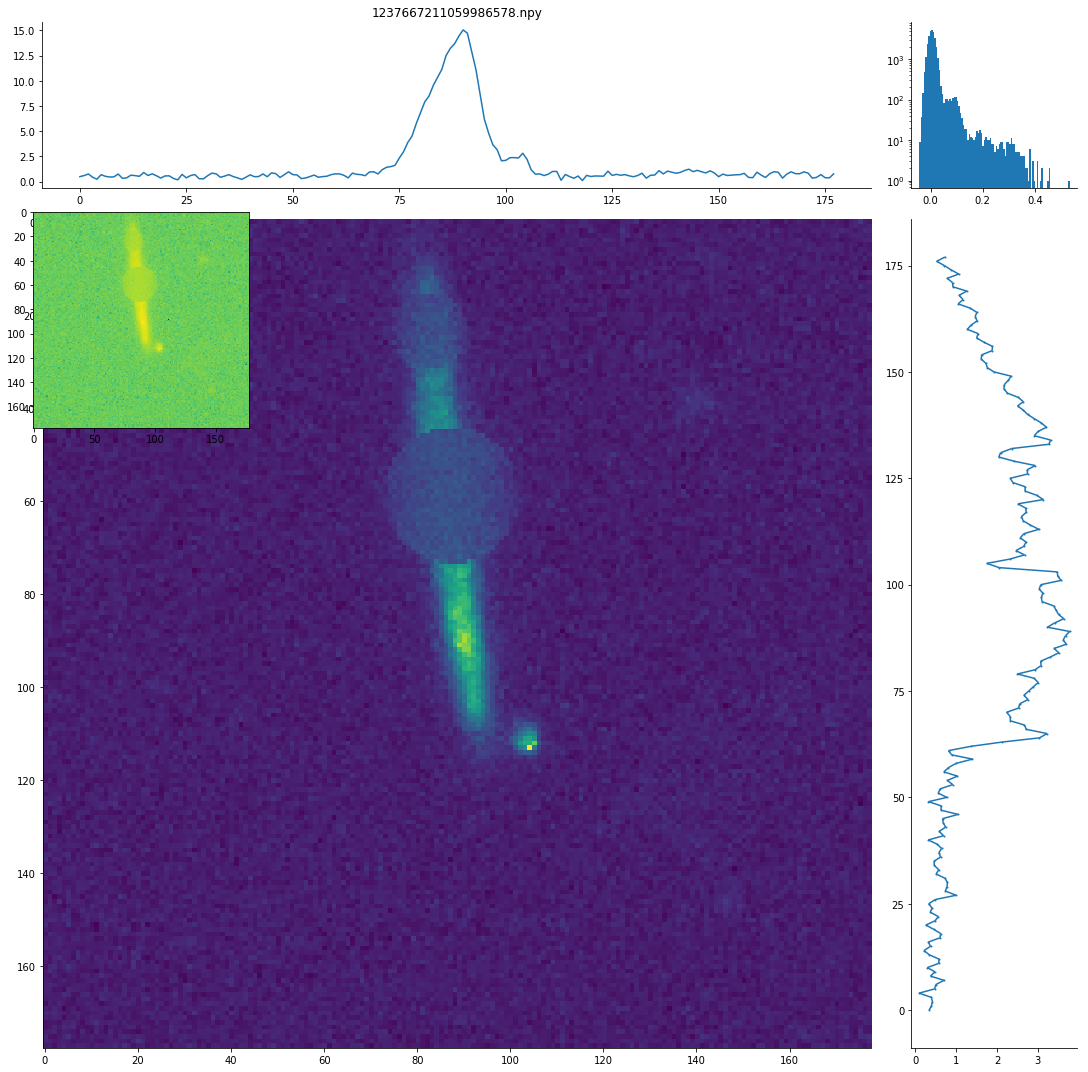

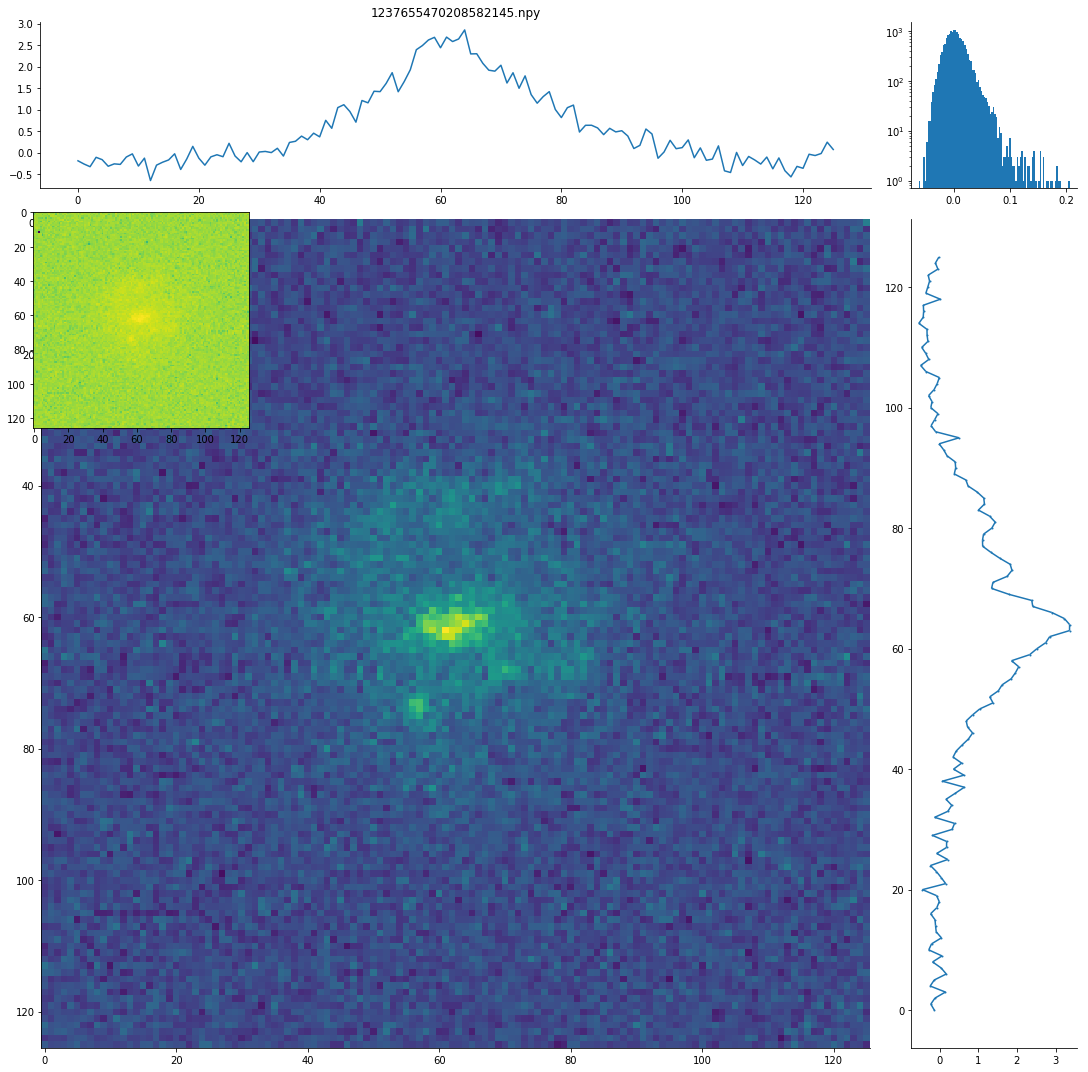

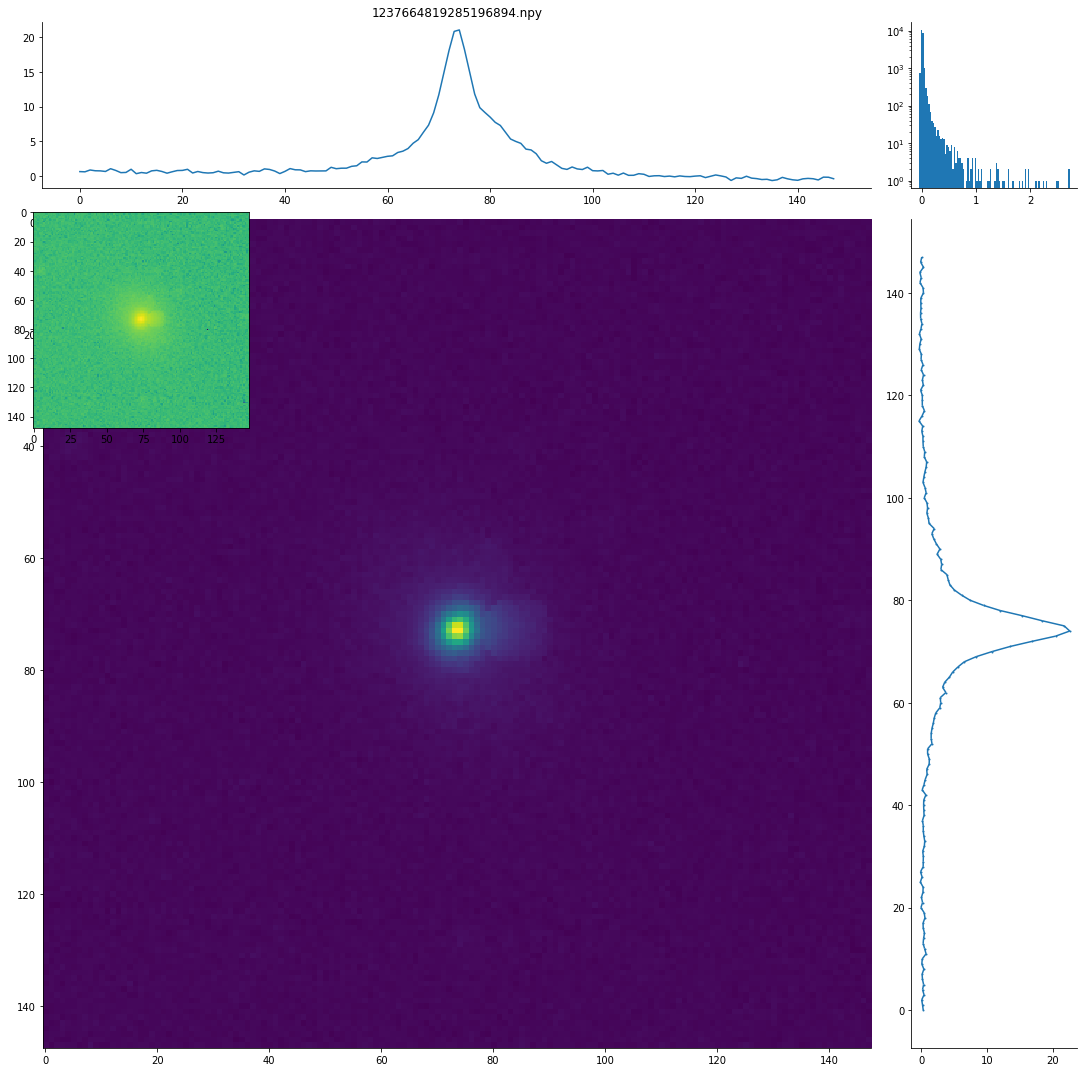

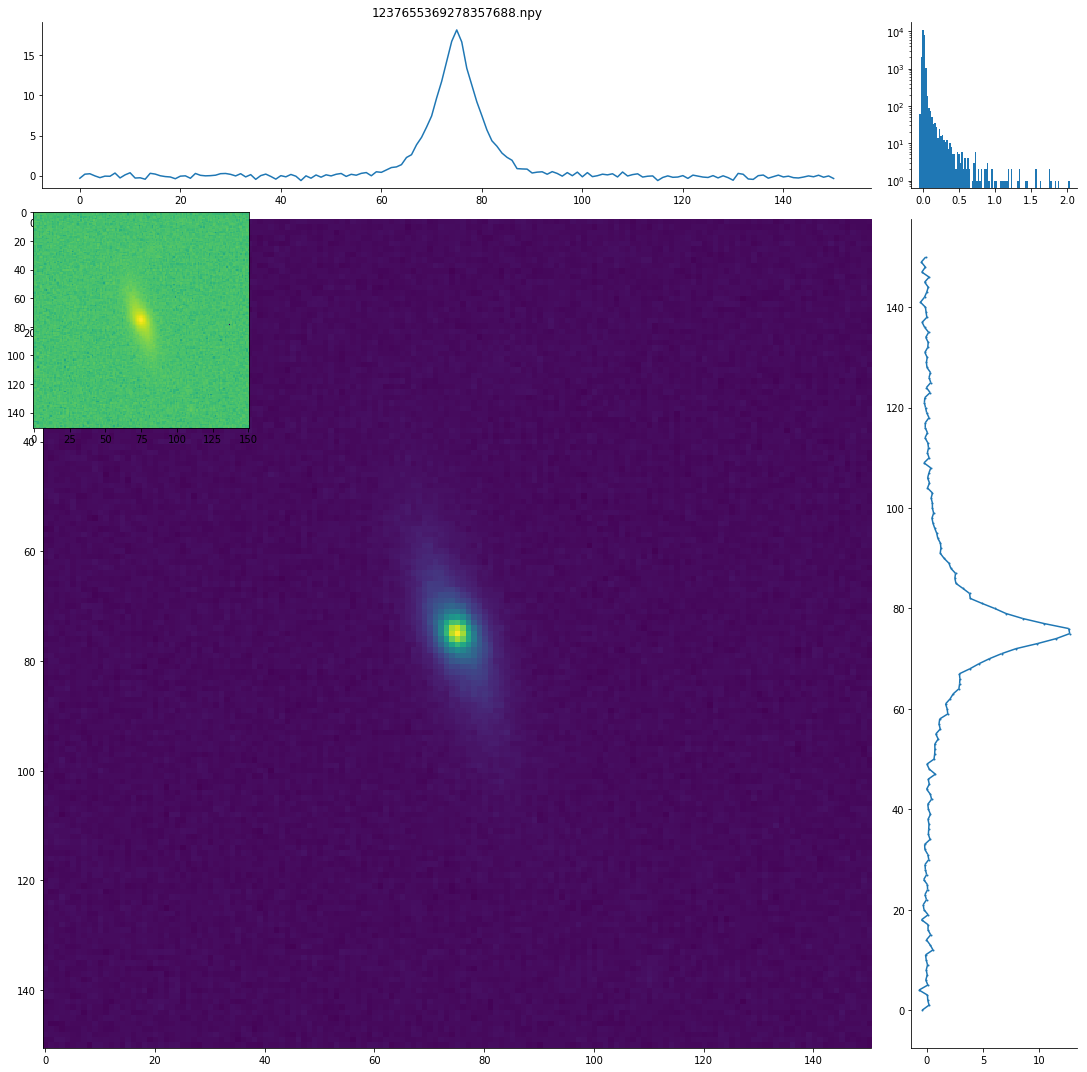

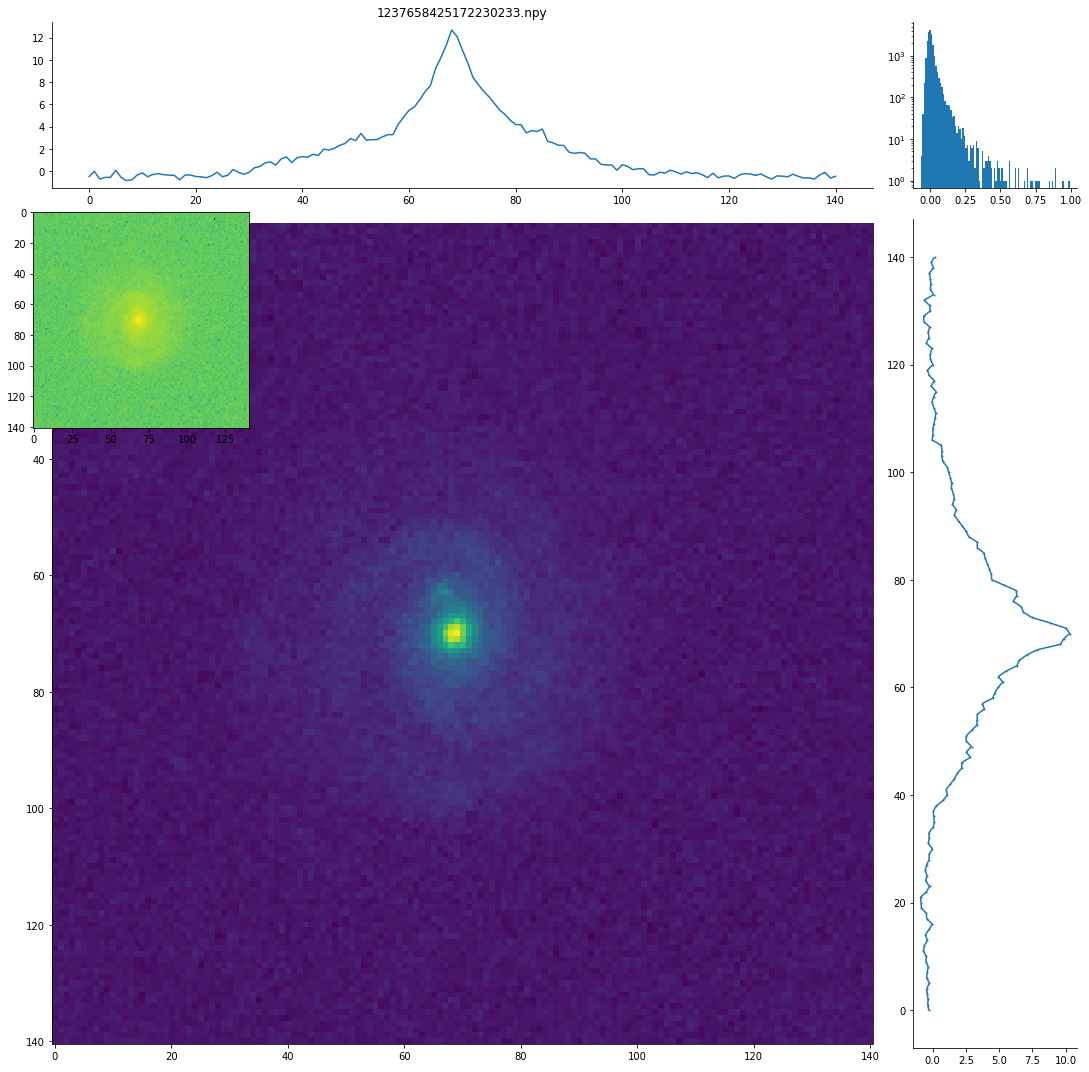

In [8]:
def drawOneGalaxy(galaxyID):
    oneImageData = read_image(galaxyID)
    print(galaxyID)

    # new image
    fig = plt.figure(figsize=(15,15))
    #set grid spec for the 4 graphs
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1,5]) 

    #draw image
    plt.title("raw")
    plt.subplot(gs[2])
    plt.imshow(oneImageData)
    
    # horizontal (top) sum
    plt.subplot(gs[0])
    plt.title(galaxyID)
    plt.plot(oneImageData.sum(axis=0))

    # vertical (bottom-right) sum
    ax = plt.subplot(gs[3])
    ss = np.flip(oneImageData.sum(axis=1),axis=0)
    plt.scatter(x=ss, y=list(range(oneImageData.shape[1])), s=1)
    lines = [[(ss[i-1],i-1),(ss[i],i)] for i in range(1,len(ss))]
    lc = matplotlib.collections.LineCollection(lines)
    ax.add_collection(lc)
    
    #value histogram
    plt.subplot(gs[1])
    plt.hist(oneImageData.reshape(-1), bins=100)
    plt.yscale('log')    
    sns.despine()
    plt.tight_layout()

    #add small log of image
    ax = fig.add_axes([0.02,0.6,.2,.2])
    plt.imshow(np.log(oneImageData-oneImageData.min()+0.00001))

for _ in range(5):
    i = random.randint(0,len(dataFileList))
#     oneImageData = np.load(dataFolder+'1237648704067273096.npy')
    drawOneGalaxy(dataFileList[i])
    


In [9]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy',
 '1237667211059986578.npy','1237655470208582145.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

In [10]:
print('test')

test


# ML part

In [11]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import xgboost as xgb
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [12]:
def xi2(true,pred,error):
    s=np.mean((true-pred)**2/error**2)
    return s

def normalize_image(Xg):
    Xg -= np.mean(Xg)
    Xg /= np.std(Xg)
    
    return Xg

def crop_image(Xg):
    h,w = Xg.shape
    cy, cx = h//2, w//2
    dy, dx = cy//2, cx//2 # crop half
    Xg = Xg[cy-dy:cy+dy,cx-dx:cx+dx]
    
    return Xg

def img_preprocnoread(Xg):
#    Xg = cleanupImage(id)
    Xg = np.log1p(Xg - Xg.min())
    Xg = normalize_image(Xg)
    Xg = crop_image(Xg)

    if Xg.shape[0] >= 224:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_AREA)
    else:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_CUBIC)
    
    return Xgr
    
def img_preproc(id):
    Xg = read_image(id)
    return img_preprocnoread(Xg)

runNameParams.append('ReadLog1pNormCrop.5')
# preprocName = "ReadNormCrop.5"
# x = img_preproc('1237662637444694216')
x = img_preproc(dataFileList[random.randint(0,len(dataFileList))])


-1.23727 15.2436
[[-0.26404506 -0.26404506 -0.28115451 -0.30582398 -0.33049342]
 [-0.26404506 -0.26404506 -0.28115451 -0.30582398 -0.33049342]
 [-0.25057524 -0.25057524 -0.27180362 -0.30241197 -0.3330203 ]
 [-0.23115364 -0.23115364 -0.2583209  -0.29749233 -0.33666372]
 [-0.21173204 -0.21173204 -0.24483819 -0.29257268 -0.34030712]]


1

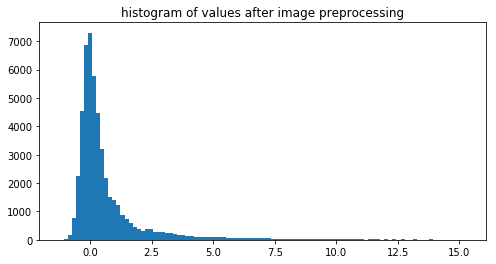

In [13]:
print(x.min(), x.max())
print(x[0:5,0:5])

plt.figure(figsize=(8,4))
plt.title('histogram of values after image preprocessing')
plt.hist(x.reshape(-1), bins=100)

1

### Load pretrained networks

In [14]:
vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

### Read metadata file

In [15]:
df =  pd.read_fwf('metaData.dat', comment = '#')
df.columns = df.iloc[9,:].values
df = df[10:]
df.head()

,SDSS_ID,RA,DEC,D25,redshi,logMst,err_l,GalSize_kpc,D_Mpc,d_pix_kpc
10,1237662635825954925,210.95489999999998,12.64455,0.33113110693986714,0.1029,-99.0,-99.0,42.47806067869379,440.99999325616017,0.8552113203991983
11,1237652947452297303,0.84015,-9.98328,0.5248074948227709,0.0767,11.312,0.016,50.181626715917524,328.7142940929958,0.6374607478101917
12,1237652899137912944,1.0026,-11.17802,0.6165950323262803,0.0383,9.708,0.071,29.440699795795908,164.1428577048438,0.3183148122868964
13,1237661433779716229,211.48905000000002,43.88251,0.7585775667003197,0.0337,9.26,0.062,31.869792393005813,144.4285735487938,0.28008379359836033
14,1237652944786555077,1.48395,16.13445,0.3388441338170015,0.0909,10.7,0.04,38.39840364463448,389.571413397789,0.7554782039377076


In [16]:
df['RA'] = df['RA'].apply(np.float64)
df['DEC'] = df['DEC'].apply(np.float64)
df['D25'] = df['D25'].apply(np.float64)
df['redshi'] = df['redshi'].apply(np.float64)
df['logMstar'] = df['logMst'].apply(np.float64) #renamed
df['err_logMstar'] = df['err_l'].apply(np.float64) #renamed
df['GalSize_kpc'] = df['GalSize_kpc'].apply(np.float64)
df['Distance'] = df['D_Mpc'].apply(np.float64) #renamed
df['d_pix_kpc'] = df['d_pix_kpc'].apply(np.float64)

df['lin_mass'] = np.power(10, df.logMstar)
df['lin_err'] = df['lin_mass'] * np.log(10) * df.err_logMstar

df = df.drop(['logMst','err_l'], axis=1)
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,1.877420e+05,1.877420e+05
mean,184.527190,24.898677,0.445798,0.074652,38.318105,0.620438,9.081941,-1.313631,319.936358,7.877701e+10,4.648110e+09
std,61.620064,19.374103,0.168006,0.040143,18.942158,0.333632,12.706553,11.469736,172.041273,9.461819e+10,5.529011e+09
min,0.008250,-11.252830,0.316228,0.010000,4.034125,0.083111,-99.000000,-99.000000,42.857142,1.000000e-99,-2.279559e-97
25%,152.349938,8.662358,0.346737,0.044100,25.157782,0.366519,10.191000,0.021000,189.000006,1.552387e+10,1.144774e+09
50%,185.824575,23.197910,0.389045,0.069000,35.525868,0.573465,10.693000,0.029000,295.714278,4.931738e+10,2.906879e+09
75%,222.151537,39.835143,0.478630,0.096400,48.283920,0.801189,11.032000,0.041000,413.142858,1.076465e+11,6.027530e+09
max,359.994900,70.133250,10.964781,0.299600,1373.931687,2.490003,12.326000,0.800000,1284.000022,2.118361e+12,1.727792e+11


In [17]:
# df.SDSS_ID[:20].apply(lambda x: x)
df['hasFile'] = df.SDSS_ID.apply(lambda x: os.path.isfile(dataFolder+x+'.npy'))

print("data file present:", len(df[df['hasFile']==True]))
print("data file missing:", len(df[df['hasFile']==False]))

data file present: 80306
data file missing: 107436


### Filter images that have no known mass, no actual image, or with an unknown error

In [18]:
df = df[df.logMstar != -99]
df = df[df.hasFile == True]
df = df[df['lin_err']!=0]
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,7.885100e+04,7.885100e+04
mean,185.303775,25.672447,0.557644,0.058701,38.101843,0.487867,10.558197,0.031070,251.574576,7.898269e+10,4.398954e+09
std,57.111612,18.944782,0.194465,0.032567,19.838329,0.270663,0.654456,0.016953,139.570856,9.624108e+10,5.552716e+09
min,0.009450,-11.238420,0.407380,0.010000,5.248929,0.083111,7.376000,0.001000,42.857142,2.376840e+07,4.756699e+05
25%,154.486425,9.795145,0.436516,0.033800,24.390653,0.280915,10.200000,0.019000,144.857136,1.584893e+10,1.023221e+09
50%,186.753000,24.400580,0.489779,0.052300,35.043089,0.434670,10.692000,0.028000,224.142852,4.920395e+10,2.693666e+09
75%,221.979375,40.093400,0.602560,0.075600,47.500516,0.628319,11.030000,0.039000,323.999992,1.071519e+11,5.603185e+09
max,359.994900,70.133250,10.964781,0.294800,1373.931687,2.450110,12.326000,0.778000,1263.428628,2.118361e+12,1.414535e+11


In [19]:
random.seed(42)

df = df.sample(frac=1).reset_index(drop=True)

In [20]:
df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
0,1237658204492595332,129.34695,33.84145,0.416869,0.0507,26.348586,217.28572036538804,0.421372,10.187,0.029,217.285720,1.538155e+10,1.027102e+09,True
1,1237658803109757228,177.00315,55.76148,0.794328,0.0516,51.097426,221.14286465304238,0.428852,11.402,0.053,221.142865,2.523481e+11,3.079580e+10,True
2,1237655744556237005,226.21050,6.13713,0.501187,0.0450,28.116538,192.85715052059717,0.373999,10.261,0.029,192.857151,1.823896e+10,1.217906e+09,True
3,1237667430632521980,144.87390,22.12224,0.436516,0.1053,57.303044,451.2857220002583,0.875158,10.987,0.024,451.285722,9.705100e+10,5.363236e+09,True
4,1237660634917109953,144.47385,39.03885,0.457088,0.1070,60.972379,458.5714318922588,0.889287,11.231,0.016,458.571432,1.702159e+11,6.270984e+09,True


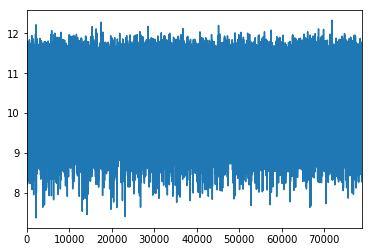

In [21]:
df.logMstar.plot()

In [22]:
print(len(df.SDSS_ID.values))

78851


# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [23]:
N = int(len(df.SDSS_ID.values))
M = int(N*.9)
prefixThisRound = 'sp'
for i in runNameParams:
    prefixThisRound = prefixThisRound + '-' + i

chunkSize = 500
# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout


In [24]:
ids = df.SDSS_ID.values[:N]
Y = df.logMstar.values[:N]
err = df.err_logMstar.values[:N]
Y_lin = df.lin_mass.values[:N]
err_lin = df.lin_err.values[:N]

In [25]:
print(N)
print(M)
print(chunkSize)
print(prefixThisRound)

78851
70965
500
sp-newSource-ReadLog1pNormCrop.5


In [26]:
# crap instruction to make the auto execution stop here :p

### call img_preproc on all images, per batches of "chunkSize"
### Generate features based on the preprocessed images, pretrained networks and flux densities

In [27]:
def chunkFileName(chunkSize, prefix, chunkNumber):
    fileName = 'Xg3-'+str(chunkSize)+'-'+prefix+'-chunk-' + str(chunkNumber) + '.npy'
    return fileName

In [28]:
reloadImagesAndPreprocess = 0
maxChunkNumber = math.ceil(len(ids)/chunkSize)

Xg3r50 = []
Xg3vgg16 = []
postImgFeatures = []
csize=2
preImgFeatures = []

chunkStart = 0
# for chunkStart in tqdm(range(0, 3)):
for chunkStart in tqdm(range(0, len(ids), chunkSize)):
    curChunk = int((chunkStart//chunkSize))
    valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart

    Xg_ = []
    pre_ex_ = []

    # preprocess the image and collect some raw image stats
    for i in range(chunkStart, chunkStart+valuesInThisChunk):
        X = read_image(ids[i])
        Xg_.append(img_preprocnoread(X))
        pre_ex_.append([
            X.sum(),
            X.min(),
            X.max(),
            X.mean(),
            X.std(),
            X[X.shape[0]//2,X.shape[1]//2],
            np.mean(X[X.shape[0]//2-csize:X.shape[0]//2+csize,X.shape[1]//2-csize:X.shape[1]//2+csize]), # mean center
            X.shape[0], 
        ])

    # reformat the postprocessing
    pre_ex = np.stack(pre_ex_)
    Xg = np.stack(Xg_)

    # collect some post processing stats
    post_ex = np.hstack([
        np.sum(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.min(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.max(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.mean(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.std(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        Xg[:,112,112].reshape(valuesInThisChunk,1),       # center
        np.mean(Xg[:,112-csize:112+csize,112-csize:112+csize].reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,-1) # mean center
        ])

    Xg3 = np.zeros((valuesInThisChunk,224,224,3))
    Xg3[:,:,:,:] = Xg.reshape(valuesInThisChunk,224,224,1)
    
    # do r50 prediction
    Xg3r50_ = r50.predict(Xg3).reshape(valuesInThisChunk, 2048)
    Xg3vgg16_ = vgg16.predict(Xg3)


    if chunkStart == 0:
        Xg3r50 = Xg3r50_
        Xg3vgg16 = Xg3vgg16_
        preImgFeatures = pre_ex
        postImgFeatures = post_ex
    else:
        Xg3r50 = np.concatenate([Xg3r50,Xg3r50_], axis=0)
        Xg3vgg16 = np.concatenate([Xg3vgg16,Xg3vgg16_], axis=0)
        preImgFeatures = np.concatenate([preImgFeatures,pre_ex], axis=0)
        postImgFeatures = np.concatenate([postImgFeatures,post_ex], axis=0)
        
print('done')

postImgFeatureNames = ['norm.flux.sum', 'norm.flux.min',
                       'norm.flux.max', 'norm.flux.mean', 
                       'norm.flux.std', 'center.flux', 
                       'aroundCenter.flux']
preImgFeatureNames = ['pre.flux.sum', 'pre.flux.min', 
                      'pre.flux.max', 'pre.flux.mean',
                      'pre.flux.std', 'pre.center.flux',
                      'pre.aroundCenter.flux', 'width']



100%|██████████| 158/158 [11:30<00:00,  4.22s/it]

done


In [29]:
Xg3 = None
Xg = None
X = None


In [30]:
Distance = df.Distance.values[:N].reshape(N,1)

Xg3f = np.hstack ( ( 
        Xg3r50, 
        Xg3vgg16, 
        Distance,
        1/Distance,
        Distance**2,
        1/(Distance**2),
        Distance**3,
        1/(Distance**3),
        np.log(Distance),
        1/np.log(Distance),
        np.log(Distance**2),
        1/np.log(Distance**2),
        np.log(Distance)**2,
        1/np.log(Distance)**2,
        preImgFeatures,
        postImgFeatures
        ) )

distanceNames = ['D', '1/D', 'D**2', '1/D**2', 'D**3', '1/D**3', 'log(D)', '1/log(D)', 'log(D**2)', 'log(1/D**2)', 'log(D)**2', '1/log(D)**2' ]

In [31]:
prefixThisRound = prefixThisRound + '-model3'

In [32]:
# extraImgFeatureNames = ['norm.flux.sum', 'norm.flux.min', 'norm.flux.max', 'norm.flux.mean', 'norm.flux.std', 'center.flux', 'aroundCenter.flux']

Xg3fNames = ( [prefixThisRound+'.r50.' + str(i) for i in range(Xg3r50.shape[1])]
            + [prefixThisRound+'.vgg16.' + str(i) for i in range(Xg3vgg16.shape[1])] 
            + [prefixThisRound+'.'+ n for n in distanceNames]
            + [prefixThisRound+'.'+ n for n in preImgFeatureNames]
            + [prefixThisRound+'.'+ n for n in postImgFeatureNames])

print(len(Xg3fNames), Xg3f.shape)

3075 (78851, 3075)


In [33]:
print(Xg3f.shape)
print(df.shape)

t1 = df.SDSS_ID.values[:N].reshape(N,1)
t2 = Xg3f[:N,:]
t3 = np.concatenate((t1,t2), axis=1)
np.save(prefixThisRound+str(N), t3)
np.save(prefixThisRound+str(N) + 'featurenames', Xg3fNames)
del t1, t2, t3

(78851, 3075)
(78851, 14)


In [34]:

# if os.path.isfile(prefixThisRound +str(N)+'.npy'):
#     t3 = np.load(prefixThisRound+str(N)+'.npy')
#     Xg3fNames = np.load(prefixThisRound+str(N) + 'featurenames' + '.npy', )
# Xg3f = t3[:,1:]
# Xg3f.shape

In [35]:
# Xg3f = t3[:,1:]
# Xg3f.shape

### Generate the train/test datasets for lgbm regression

In [36]:
# N = len(df.SDSS_ID.values)
# M = 4000

# N = 10000
# M = 10000
print(M, N)

70965 78851


In [37]:
dtrain = lgbm.Dataset(Xg3f[:M], label= Y[:M])
dtest = lgbm.Dataset(Xg3f[M:], label= Y[M:])


In [38]:

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    #'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [39]:
# useless cv if not used
# bst=lgbm.cv(lgbm_params, dtrain, num_boost_round=10000, nfold=3, stratified=False, shuffle=True,
#               metrics=None, fobj=None, feval=None, init_model=None, feature_name='auto',
#               categorical_feature='auto', early_stopping_rounds=100, fpreproc=None,
#               verbose_eval=5, show_stdv=True, seed=0, callbacks=None)



In [40]:

# num_boost_round = len(bst['rmse-mean'])-1
num_boost_round = 9999
print(num_boost_round)


9999


In [41]:
from sklearn.metrics import *

def lgb_rmsle(y_pred,y_true):
   return 'rmsle', mean_squared_error(np.log1p(y_true.get_label()),np.log1p(y_pred)), False

In [42]:
model = lgbm.train(lgbm_params, dtrain, num_boost_round,
                   valid_sets=[dtest], valid_names=['test'], fobj=None, feval=lgb_rmsle, 
                   init_model=None, feature_name='auto', categorical_feature='auto', 
                   early_stopping_rounds=100, evals_result=None, verbose_eval=20, 
                   learning_rates=None, callbacks=None)


Training until validation scores don't improve for 100 rounds.
[20]	test's rmse: 0.560945	test's rmsle: 0.0025128
[40]	test's rmse: 0.4915	test's rmsle: 0.00194039
[60]	test's rmse: 0.435624	test's rmsle: 0.00153047
[80]	test's rmse: 0.390816	test's rmsle: 0.00123495
[100]	test's rmse: 0.354984	test's rmsle: 0.00101997
[120]	test's rmse: 0.326432	test's rmsle: 0.000862528
[140]	test's rmse: 0.303366	test's rmsle: 0.000744375
[160]	test's rmse: 0.285297	test's rmsle: 0.000657767
[180]	test's rmse: 0.271493	test's rmsle: 0.000595048
[200]	test's rmse: 0.260677	test's rmsle: 0.000548112
[220]	test's rmse: 0.252004	test's rmsle: 0.000511771
[240]	test's rmse: 0.244745	test's rmsle: 0.000482351
[260]	test's rmse: 0.23888	test's rmsle: 0.000459263
[280]	test's rmse: 0.234044	test's rmsle: 0.000440679
[300]	test's rmse: 0.230088	test's rmsle: 0.00042574
[320]	test's rmse: 0.226724	test's rmsle: 0.000413262
[340]	test's rmse: 0.223801	test's rmsle: 0.000402574
[360]	test's rmse: 0.221217	test'

[3020]	test's rmse: 0.184202	test's rmsle: 0.000273553
[3040]	test's rmse: 0.184165	test's rmsle: 0.000273451
[3060]	test's rmse: 0.184122	test's rmsle: 0.000273328
[3080]	test's rmse: 0.184103	test's rmsle: 0.000273273
[3100]	test's rmse: 0.18407	test's rmsle: 0.000273181
[3120]	test's rmse: 0.184044	test's rmsle: 0.000273108
[3140]	test's rmse: 0.184016	test's rmsle: 0.000273032
[3160]	test's rmse: 0.183982	test's rmsle: 0.000272939
[3180]	test's rmse: 0.183938	test's rmsle: 0.000272814
[3200]	test's rmse: 0.1839	test's rmsle: 0.000272707
[3220]	test's rmse: 0.183875	test's rmsle: 0.000272634
[3240]	test's rmse: 0.183846	test's rmsle: 0.00027255
[3260]	test's rmse: 0.183838	test's rmsle: 0.000272534
[3280]	test's rmse: 0.183796	test's rmsle: 0.000272414
[3300]	test's rmse: 0.183776	test's rmsle: 0.000272353
[3320]	test's rmse: 0.183754	test's rmsle: 0.00027229
[3340]	test's rmse: 0.183729	test's rmsle: 0.000272229
[3360]	test's rmse: 0.183712	test's rmsle: 0.000272178
[3380]	test's r

[6020]	test's rmse: 0.181355	test's rmsle: 0.000265514
[6040]	test's rmse: 0.181346	test's rmsle: 0.000265489
[6060]	test's rmse: 0.181334	test's rmsle: 0.000265453
[6080]	test's rmse: 0.181335	test's rmsle: 0.000265456
[6100]	test's rmse: 0.181321	test's rmsle: 0.000265415
[6120]	test's rmse: 0.181307	test's rmsle: 0.000265373
[6140]	test's rmse: 0.181287	test's rmsle: 0.000265315
[6160]	test's rmse: 0.181285	test's rmsle: 0.000265311
[6180]	test's rmse: 0.181267	test's rmsle: 0.00026526
[6200]	test's rmse: 0.181259	test's rmsle: 0.000265237
[6220]	test's rmse: 0.181252	test's rmsle: 0.000265216
[6240]	test's rmse: 0.181239	test's rmsle: 0.000265179
[6260]	test's rmse: 0.181225	test's rmsle: 0.000265137
[6280]	test's rmse: 0.181225	test's rmsle: 0.000265141
[6300]	test's rmse: 0.181212	test's rmsle: 0.000265106
[6320]	test's rmse: 0.181197	test's rmsle: 0.000265063
[6340]	test's rmse: 0.181182	test's rmsle: 0.000265023
[6360]	test's rmse: 0.181173	test's rmsle: 0.000265001
[6380]	test

[9020]	test's rmse: 0.180057	test's rmsle: 0.000261872
[9040]	test's rmse: 0.180053	test's rmsle: 0.000261858
[9060]	test's rmse: 0.180052	test's rmsle: 0.000261859
[9080]	test's rmse: 0.180041	test's rmsle: 0.00026183
[9100]	test's rmse: 0.180034	test's rmsle: 0.000261811
[9120]	test's rmse: 0.180031	test's rmsle: 0.000261801
[9140]	test's rmse: 0.180034	test's rmsle: 0.00026181
[9160]	test's rmse: 0.180027	test's rmsle: 0.00026179
[9180]	test's rmse: 0.180007	test's rmsle: 0.000261733
[9200]	test's rmse: 0.180004	test's rmsle: 0.000261729
[9220]	test's rmse: 0.179993	test's rmsle: 0.000261696
[9240]	test's rmse: 0.179989	test's rmsle: 0.000261688
[9260]	test's rmse: 0.179979	test's rmsle: 0.000261657
[9280]	test's rmse: 0.179963	test's rmsle: 0.000261611
[9300]	test's rmse: 0.179956	test's rmsle: 0.000261589
[9320]	test's rmse: 0.179947	test's rmsle: 0.000261562
[9340]	test's rmse: 0.179944	test's rmsle: 0.000261555
[9360]	test's rmse: 0.179935	test's rmsle: 0.000261533
[9380]	test's

In [43]:
pred = model.predict(Xg3f[M:])

In [44]:
print(Y[M:].shape)
print(pred.shape)

(7886,)
(7886,)


In [45]:
chiSq = xi2(Y[M:],pred,err[M:])
linChiSq = xi2(10**Y[M:],10**pred,err_lin[M:])
print(chiSq)
print(linChiSq)


64.4120566007
82.1151002172


In [46]:
print(N,(M,N-M), prefixThisRound, chiSq, linChiSq)
# 7885 (6308, 1577) sp-newSource-ReadNormCrop.5-model1 65.6004981632 289.265891446
# 78851 (63080, 15771) sp-newSource-ReadNormCrop.5-model1 101.26977686 3634.92854724
# 78851 (70965, 7886) sp-newSource-ReadNormCrop.5-model1 84.7537916939 112.786722095
# 78851 (70965, 7886) sp-newSource-ReadNormCrop.5-model1-model2 76.9540798979 106.544584929

78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.5-model3 64.4120566007 82.1151002172


In [47]:
# investigateIDOffset = 2815

# df.loc[M+investigateIDOffset,:]

# print(10**pred[investigateIDOffset]/10**Y[M+investigateIDOffset], 10**Y[M+investigateIDOffset])

# drawOneGalaxy(df.loc[M+investigateIDOffset,'SDSS_ID'])

In [48]:
# def xi2_max(true,pred,error):
#     s=np.argmax((true-pred)**2/error**2)
    
#     plt.hist(np.log(0.00001+(true-pred)**2/error**2),bins=100)
#     return s

In [49]:
# # M = N-4000
# pred[2815] = Y[M+2815]

# print( xi2_max(10**Y[M:],10**pred,err_lin[M:]))


In [50]:
# kf = KFold(n_splits=5,shuffle=True, random_state=220673)


# [6:26] 
# for tix, vix in kf.split(x[:-1]):
#        X_train, X_test = x[tix], x[vix]
#        Y_train, Y_test = y[tix], y[vix]


# [6:27] 
# lgb_train = lgb.Dataset(X_train, Y_train, categorical_feature=cat)
#        lgb_eval = lgb.Dataset(X_test, Y_test, categorical_feature=cat)


# [6:27] 
# gbm = lgb.train(params,
#                        lgb_train,
#                        num_boost_round=10000,
#                        valid_sets=[lgb_train,lgb_eval],  # eval training data
#                        #categorical_feature=
#                        verbose_eval=100,
#                        early_stopping_rounds=1000,
#                        feval=lgb_r2,
#                        categorical_feature=cat
#                       )


# [6:28] 
# def lgb_r2(y_pred,y_true):
#    return ‘r2’, r2_score(y_true.get_label(),y_pred), True


# [6:28] 
# gbm.predict(X_test,gbm.best_iteration)

# Model is trained, values are obtained, saving and result analysis below

In [51]:
# break here, save the stuff below

In [52]:
arr = model.feature_importance()
print(arr.shape)
np.argmax(arr)
# print(arr)

(3075,)


3048

In [53]:
fimport = list(zip(arr, Xg3fNames))
sorted(fimport, key=lambda x: x[0], reverse=True)

[(3776, 'sp-newSource-ReadLog1pNormCrop.5-model3.D'),
 (3146, 'sp-newSource-ReadLog1pNormCrop.5-model3.norm.flux.sum'),
 (2700, 'sp-newSource-ReadLog1pNormCrop.5-model3.1/D'),
 (1786, 'sp-newSource-ReadLog1pNormCrop.5-model3.width'),
 (1581, 'sp-newSource-ReadLog1pNormCrop.5-model3.pre.flux.std'),
 (1496, 'sp-newSource-ReadLog1pNormCrop.5-model3.pre.flux.sum'),
 (1210, 'sp-newSource-ReadLog1pNormCrop.5-model3.pre.aroundCenter.flux'),
 (1014, 'sp-newSource-ReadLog1pNormCrop.5-model3.pre.flux.mean'),
 (610, 'sp-newSource-ReadLog1pNormCrop.5-model3.pre.flux.min'),
 (601, 'sp-newSource-ReadLog1pNormCrop.5-model3.center.flux'),
 (514, 'sp-newSource-ReadLog1pNormCrop.5-model3.aroundCenter.flux'),
 (417, 'sp-newSource-ReadLog1pNormCrop.5-model3.pre.center.flux'),
 (364, 'sp-newSource-ReadLog1pNormCrop.5-model3.norm.flux.std'),
 (305, 'sp-newSource-ReadLog1pNormCrop.5-model3.r50.108'),
 (303, 'sp-newSource-ReadLog1pNormCrop.5-model3.vgg16.787'),
 (248, 'sp-newSource-ReadLog1pNormCrop.5-model3.

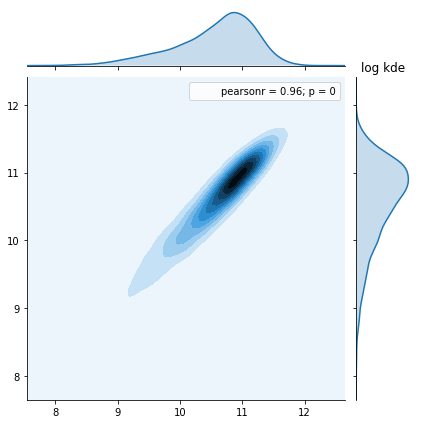

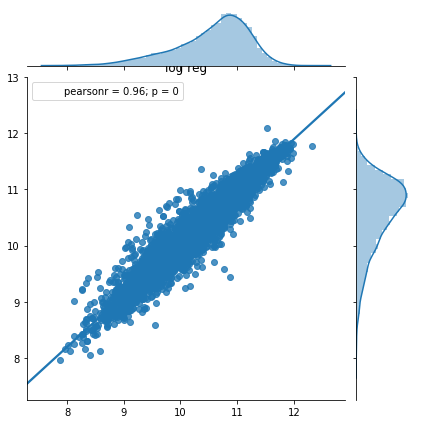

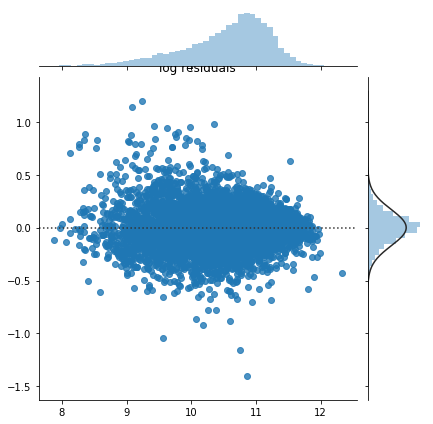

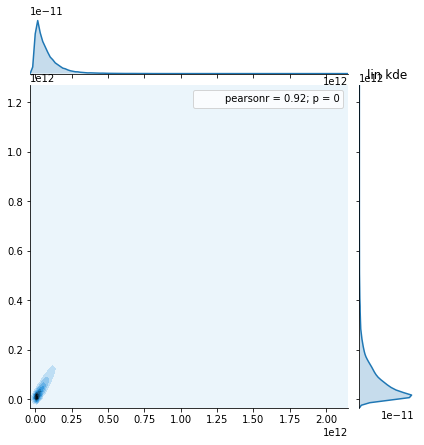

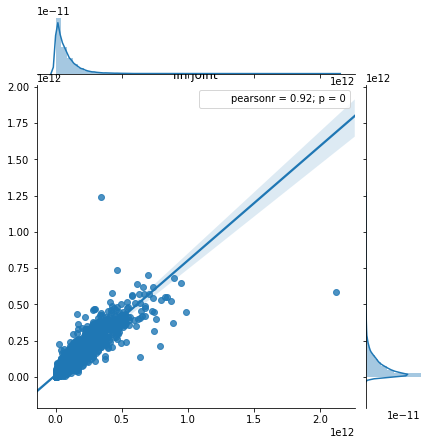

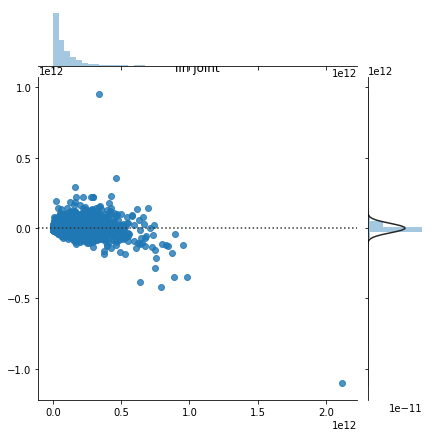

In [54]:
sns.jointplot(x=Y[M:], y=pred, kind='kde')
plt.title('log kde')
sns.jointplot(x=Y[M:], y=pred, kind='reg')
plt.title('log reg')
sns.jointplot(x=Y[M:], y=pred, kind='resid')
plt.title('log residuals')


sns.jointplot(x=10**Y[M:], y=10**pred, kind='kde')
plt.title('lin kde')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='reg')
plt.title('lin joint')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='resid')
plt.title('lin joint')
# plt.scatter(x=10**Y[M:], y=10**pred)
